# Import libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import os
import geopandas as gpd
from Bio import Entrez
import time
from tqdm import tqdm
import requests
from Bio import Entrez
import gzip
import subprocess 
from scipy.spatial.distance import cdist

# Read the data

In [ ]:
# Read the data 
df = pd.read_csv("/home/chandru/binp37/results/metasub/processed_metasub.csv")
df.head()

In [ ]:
rfe_df = pd.read_csv("/home/chandru/binp37/results/metasub/metasub_training_testing_data.csv")
rfe_df.head()

# Geograpical features

In [ ]:
feature_data = df[['city_total_population','city_population_density',
                  'city_land_area_km2','city_ave_june_temp_c','city_elevation_meters','city_koppen_climate','continent','city','latitude','longitude']]

# Fix city elevation of hanoi, yamaguchi in meters
feature_data.loc[feature_data['city'] == 'hanoi','city_elevation_meters'] = 12
feature_data.loc[feature_data['city'] == 'yamaguchi','city_elevation_meters'] = 23
feature_data.loc[feature_data['city'] == 'marseille','city_elevation_meters'] = 42 # city elevation of marseille on google is 42 m here it is 0

# Get city population density, city ladn ares in km2, city avg temp in june and city elevation in meters of offa 
offa_data = {
    'city_population_density': 2500.0,
    'city_land_area_km2': 74.0,
    'city_ave_june_temp_c': 28.0,
    'city_elevation_meters': 457.0
}

feature_data.loc[feature_data['city'] == 'offa', list(offa_data.keys())] = list(offa_data.values())

# Get city land area in km2 of marseille  
feature_data.loc[feature_data['city'] == 'marseille','city_land_area_km2'] = 240

# Fix all the nan values of london
london_data = {
    'city_total_population': 8787892.0,
    'city_population_density': 5590.0,
    'city_land_area_km2': 1572.0,
    'city_ave_june_temp_c': 14.4,
    'city_elevation_meters': 11.0,
    'city_koppen_climate': 'marine_west_coast_climate'
}
feature_data.loc[feature_data['city'] == 'london', list(london_data.keys())] = list(london_data.values())


feature_data.head()

## Scaling the features

In [ ]:
# Check for skewness in the data before appling long transformer -> 
# Note to self: The city_land_area_km2 is right skewed, so we will go with log scale transformation
#             : THe city_elevation_meters is multi modal there we will go with QuantileTransformer


# Microbiome features

In [46]:
# We can get the raw sequence of all these top hundered species and get a phylogenetic tree to determine the relationship between species.
# We can then use the information as well as a feature to predict the lat and long.

microbe_data = rfe_df.iloc[:,:-4]
microbe_data

,Acidovorax ebreus,Acidovorax sp. JS42,Acidovorax sp. KKS102,Acinetobacter baumannii,Acinetobacter haemolyticus,Acinetobacter johnsonii,Acinetobacter junii,Acinetobacter pittii,Acinetobacter schindleri,Acinetobacter sp. LoGeW2-3,...,Thermothelomyces thermophila,Thielavia terrestris,Truepera radiovictrix,Tsukamurella sp. MH1,Variovorax boronicumulans,Variovorax paradoxus,Variovorax sp. PAMC 28711,Veillonella parvula,Weissella cibaria,Xanthomonas campestris
0,0.00000,0.00000,0.00023,0.00015,0.00000,0.00006,0.00001,0.00007,0.00010,0.00005,...,0.00000,0.00000,0.00000,0.00000,0.00031,0.00075,0.00021,0.00000,0.00000,0.00480
1,0.00000,0.00001,0.00003,0.00028,0.00016,0.00142,0.00017,0.00013,0.00262,0.00140,...,0.00001,0.00001,0.00000,0.00000,0.00013,0.00024,0.00003,0.00000,0.00000,0.00091
2,0.00003,0.00000,0.00011,0.00181,0.00060,0.00274,0.00030,0.00110,0.00191,0.00132,...,0.00000,0.00002,0.00000,0.00000,0.00010,0.00025,0.00001,0.00000,0.00000,0.00208
3,0.00000,0.00000,0.00000,0.00002,0.00001,0.00003,0.00000,0.00000,0.00003,0.00001,...,0.00001,0.00000,0.00000,0.00000,0.00003,0.00002,0.00000,0.00000,0.00000,0.00137
4,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00002,0.00009,0.00001,...,0.00000,0.00000,0.00000,0.00000,0.00004,0.00008,0.00003,0.00000,0.00000,0.00397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4065,0.00044,0.00052,0.00019,0.00072,0.00015,0.01410,0.00036,0.00046,0.00052,0.00024,...,0.00091,0.00124,0.00009,0.00000,0.00037,0.00107,0.00016,0.00042,0.00013,0.00132
4066,0.00000,0.00000,0.00022,0.00014,0.00000,0.00019,0.00000,0.00000,0.00000,0.00000,...,0.01762,0.00703,0.00000,0.00105,0.00147,0.00350,0.00113,0.00012,0.00002,0.00079
4067,0.00003,0.00002,0.00002,0.00018,0.00009,0.00055,0.00006,0.00019,0.00009,0.00001,...,0.00023,0.00031,0.00002,0.00006,0.00005,0.00016,0.00011,0.00057,0.00001,0.00043
4068,0.00026,0.00038,0.00051,0.00009,0.00000,0.00025,0.00004,0.00010,0.00006,0.00000,...,0.00443,0.00535,0.00000,0.00186,0.00128,0.00304,0.00126,0.00013,0.00008,0.00106


## Phylogenetic Trees

In [47]:
species_list = []
for name in microbe_data.columns:
    species_list.append(name)
    print(name)

Acidovorax ebreus
Acidovorax sp. JS42
Acidovorax sp. KKS102
Acinetobacter baumannii
Acinetobacter haemolyticus
Acinetobacter johnsonii
Acinetobacter junii
Acinetobacter pittii
Acinetobacter schindleri
Acinetobacter sp. LoGeW2-3
Actinomyces radicidentis
Aeromonas sp. ASNIH5
Alteromonas macleodii
Arsenicicoccus sp. oral taxon 190
Bacillus megaterium
Bacillus subtilis
Bradyrhizobium diazoefficiens
Bradyrhizobium japonicum
Bradyrhizobium sp.
Bradyrhizobium sp. BTAi1
Bradyrhizobium sp. CCGE-LA001
Bradyrhizobium sp. S23321
Bradyrhizobium sp. SK17
Brevundimonas naejangsanensis
Brevundimonas sp. DS20
Brevundimonas sp. GW460-12-10-14-LB2
Brevundimonas sp. LM2
Brevundimonas subvibrioides
Brevundimonas vesicularis
Brochothrix thermosphacta
Calothrix sp. NIES-4071
Candida dubliniensis
Carnobacterium inhibens
Chroococcidiopsis thermalis
Chryseobacterium indologenes
Chryseobacterium taklimakanense
Clavibacter michiganensis
Corynebacterium callunae
Corynebacterium efficiens
Corynebacterium kroppenste

In [ ]:

Entrez.email = "1ms19bt011@gmail.com" # Remember to set your actual email

def download_genome(species, output_dir="genomes"):
    """
    Downloads the complete genome for a given species from NCBI RefSeq,
    handling both FTP and HTTP URLs.

    Args:
        species (str): The scientific name of the species (e.g., "Escherichia coli").
        output_dir (str): The directory where the genome file will be saved.

    Returns:
        bool: True if the genome was successfully downloaded and decompressed, False otherwise.
    """
    os.makedirs(output_dir, exist_ok=True)

    search_terms = [
        f'"{species}"[Organism] AND "complete genome"[Assembly Level]',
        f'"{species}"[Organism] AND "reference genome"[Refseq Category]',
        f'"{species}"[Organism] AND latest[filter]',
        f'"{species}"[Organism]' # Broadest term as a last resort
    ]

    for term_index, term in enumerate(search_terms):
        print(f"Searching for '{species}' with term: '{term}'")
        try:
            # Search for latest RefSeq assembly
            handle = Entrez.esearch(db="assembly", term=term, retmax=1)
            record = Entrez.read(handle)
            handle.close() # Always close the handle

            if record["IdList"]:
                assembly_id = record["IdList"][0]
                print(f"Found assembly ID: {assembly_id} for {species}")

                # Fetch summary to get FTP path
                summary_handle = Entrez.esummary(db="assembly", id=assembly_id)
                doc = Entrez.read(summary_handle)
                summary_handle.close() # Always close the handle

                ftp_path = doc["DocumentSummarySet"]["DocumentSummary"][0]["FtpPath_RefSeq"]
                if ftp_path:
                    filename_stem = ftp_path.split("/")[-1]
                    fasta_url = f"{ftp_path}/{filename_stem}_genomic.fna.gz"
                    output_gz_path = os.path.join(output_dir, f"{species.replace(' ', '_')}.fna.gz")
                    output_fna_path = os.path.join(output_dir, f"{species.replace(' ', '_')}.fna")

                    print(f"Attempting to download from: {fasta_url}")

                    try:
                        if fasta_url.startswith("ftp://"):
                            # Use wget for FTP paths
                            print(f"Using wget for FTP download: {fasta_url}")
                            # -q for quiet, -O for output file, --show-progress for progress bar
                            # --no-verbose for cleaner output
                            # Use subprocess.run for better control and error handling than os.system
                            result = subprocess.run(
                                ["wget", "--no-verbose", "--show-progress", "-O", output_gz_path, fasta_url],
                                check=True, # Raise CalledProcessError if wget returns non-zero exit code
                                capture_output=True, # Capture stdout/stderr for debugging if needed
                                text=True # Decode stdout/stderr as text
                            )
                            # print(result.stdout) # Uncomment for detailed wget output
                            # print(result.stderr) # Uncomment for detailed wget output
                            print(f"Downloaded {species} to {output_gz_path} using wget.")
                        else:
                            # Use requests for HTTP/HTTPS paths
                            print(f"Using requests for HTTP/HTTPS download: {fasta_url}")
                            response = requests.get(fasta_url, stream=True)
                            response.raise_for_status() # Raise an exception for HTTP errors

                            total_size_in_bytes = int(response.headers.get('content-length', 0))
                            block_size = 1024 # 1 Kibibyte
                            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True, desc=f"Downloading {species}")

                            with open(output_gz_path, 'wb') as f:
                                for chunk in response.iter_content(chunk_size=block_size):
                                    progress_bar.update(len(chunk))
                                    f.write(chunk)
                            progress_bar.close()

                            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                                print("ERROR, something went wrong during download!")
                                return False
                            print(f"Downloaded {species} to {output_gz_path} using requests.")

                        # Decompress the file, regardless of how it was downloaded
                        print(f"Decompressing {output_gz_path}...")
                        with gzip.open(output_gz_path, 'rb') as f_in:
                            with open(output_fna_path, 'wb') as f_out:
                                f_out.write(f_in.read())
                        os.remove(output_gz_path) # Remove the compressed file
                        print(f"Decompressed to {output_fna_path}")
                        return True
                    except subprocess.CalledProcessError as sub_e:
                        print(f"wget failed for {species} from {fasta_url}: {sub_e}")
                        print(f"wget stdout: {sub_e.stdout}")
                        print(f"wget stderr: {sub_e.stderr}")
                        continue # Try next search term
                    except requests.exceptions.RequestException as req_e:
                        print(f"Download failed for {species} from {fasta_url}: {req_e}")
                        continue # Try next search term
                    except Exception as download_e:
                        print(f"An unexpected error occurred during download/decompression for {species}: {download_e}")
                        continue # Try next search term
                else:
                    print(f"No FTP path found for {species} with term '{term}'. Trying next search term.")
            else:
                print(f"No assembly found for {species} with term '{term}'. Trying next search term.")
            time.sleep(1) # Small delay between Entrez calls to be polite
        except Exception as e:
            print(f"Error during Entrez search for {species} with term '{term}': {e}")
            time.sleep(2) # Longer delay if Entrez call itself fails
    print(f"Failed to download genome for {species} after trying all search terms.")
    return False


output_directory = "genomes"
os.makedirs(output_directory, exist_ok=True)

# Process each species in the list
print("\nStarting genome download process...")
for species in tqdm(species_list[:], desc="Overall Genome Download Progress"):
    print(f"\nProcessing species: {species}")
    success = download_genome(species, output_directory)
    if not success:
        print(f"Could not download genome for {species}. Please check the species name or try again later.")
    time.sleep(2) # Respect NCBI rate limits between species

## Clutering using K-means

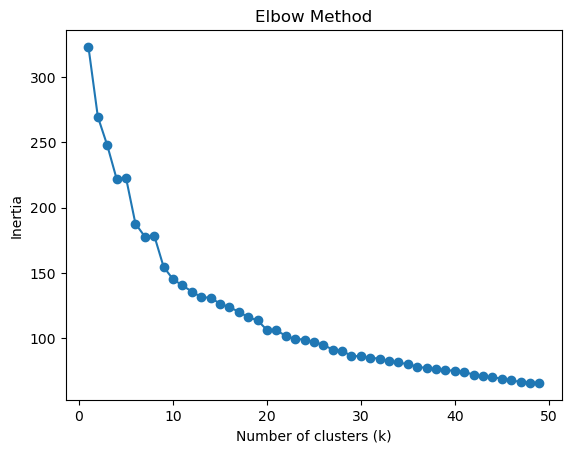

In [ ]:
# Elbow method to determine ideal cluster size -> Note I am getting the cut iff to be 15.
# Calculate inertia for k=1 to 50
inertias = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(np.array(microbe_data))
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
plt.plot(range(1, 50), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [48]:
kmeans = KMeans(n_clusters=15, random_state=42, n_init="auto").fit(np.array(microbe_data))
kmeans.cluster_centers_


centorid_distances = cdist(np.array(microbe_data),kmeans.cluster_centers_,"euclidean")
closet_indices = np.argmin(centorid_distances,axis=0)

augment_data = pd.concat([microbe_data,pd.DataFrame(centorid_distances)],axis=1)
augment_data

,Acidovorax ebreus,Acidovorax sp. JS42,Acidovorax sp. KKS102,Acinetobacter baumannii,Acinetobacter haemolyticus,Acinetobacter johnsonii,Acinetobacter junii,Acinetobacter pittii,Acinetobacter schindleri,Acinetobacter sp. LoGeW2-3,...,5,6,7,8,9,10,11,12,13,14
0,0.00000,0.00000,0.00023,0.00015,0.00000,0.00006,0.00001,0.00007,0.00010,0.00005,...,0.520114,0.507450,0.550363,0.357396,0.438075,0.576814,0.709713,0.397014,0.546556,0.458343
1,0.00000,0.00001,0.00003,0.00028,0.00016,0.00142,0.00017,0.00013,0.00262,0.00140,...,0.634177,0.626626,0.660981,0.510492,0.572373,0.682677,0.799624,0.540779,0.659134,0.586014
2,0.00003,0.00000,0.00011,0.00181,0.00060,0.00274,0.00030,0.00110,0.00191,0.00132,...,0.440937,0.429635,0.468738,0.232203,0.344387,0.509370,0.656040,0.289831,0.474946,0.308459
3,0.00000,0.00000,0.00000,0.00002,0.00001,0.00003,0.00000,0.00000,0.00003,0.00001,...,0.574740,0.567942,0.608591,0.438463,0.508287,0.628488,0.755084,0.472688,0.604349,0.175754
4,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00002,0.00009,0.00001,...,0.592451,0.583026,0.620675,0.458743,0.524744,0.647001,0.766150,0.490668,0.618294,0.233432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4065,0.00044,0.00052,0.00019,0.00072,0.00015,0.01410,0.00036,0.00046,0.00052,0.00024,...,0.335675,0.498565,0.557817,0.343037,0.393140,0.592058,0.365881,0.243661,0.524719,0.498838
4066,0.00000,0.00000,0.00022,0.00014,0.00000,0.00019,0.00000,0.00000,0.00000,0.00000,...,0.442085,0.431791,0.489393,0.250152,0.349200,0.524742,0.648107,0.293467,0.479045,0.417771
4067,0.00003,0.00002,0.00002,0.00018,0.00009,0.00055,0.00006,0.00019,0.00009,0.00001,...,0.344581,0.362908,0.427041,0.068405,0.244216,0.467966,0.546102,0.112826,0.411646,0.343418
4068,0.00026,0.00038,0.00051,0.00009,0.00000,0.00025,0.00004,0.00010,0.00006,0.00000,...,0.350982,0.378644,0.439209,0.127634,0.271976,0.478112,0.607567,0.195769,0.424856,0.357253
